In [1]:
import sklearn
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import re
from math import log
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
df = pd.read_csv('jobs.csv')
df = df.sample(frac=1)

In [3]:
df_train, df_test = df.iloc[:1200], df.iloc[1200:]

##### Extracting vocabulary from the training set

In [4]:
finder = re.compile('\w\w\w\w\w\w\w\w\w+')    #finding words with 9 consecutive characters

In [5]:
def initCorpus(df):
    corpus = []
    for title in df.Title:
        corpus.append(finder.findall(title.lower()))
    corpus = [listToDict(title) for title in corpus]
    return corpus

In [6]:
def listToDict(title):
    d = {}
    words = set(title)
    for word in words:
        d[word] = title.count(word)
    return d

In [7]:
train_corpus = initCorpus(df_train)
test_corpus = initCorpus(df_test)

##### Total number of distinct words

In [8]:
train_words = reduce(lambda x,y: x|y, [set(title.keys()) for title in train_corpus])
print 'There are %d distinct words in the titles from the training set' % len(train_words)

There are 401 distinct words in the titles from the training set


##### Computing the inverse document frequency of each word in the vocabulary

In [9]:
def computeIdf(corpus, words, min_freq):
    idf = {}
    for k, word in enumerate(words):
        d = 0
        for title in corpus:
            if word in title: 
                d+=1
        if d >= min_freq:            
            idf[word] = log(float(len(corpus))/(1+d))
    v = [[idf[word],word] for word in idf]  
    v.sort()
    words = [word for freq, word in v]
    return idf,words

In [10]:
idf, train_words = computeIdf(train_corpus, train_words, min_freq=5)

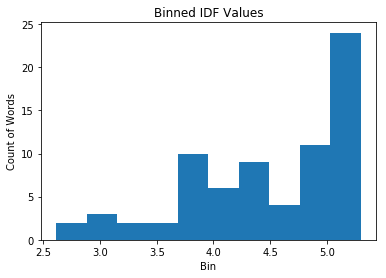

In [11]:
figure(figsize=(6,4))
plt.hist(idf.values())
plt.xlabel('Bin')
plt.ylabel('Count of Words')
plt.title('Binned IDF Values')
plt.show()

##### The top 10 and bottom 10 words by idf  

In [12]:
print 'The top 10 words by idf are %s:' % train_words[-10:]
print '\nThe bottom 10 words by idf are: %s' % train_words[:10]

The top 10 words by idf are ['environmental', 'installation', 'laboratory', 'lauderdale', 'louisville', 'professional', 'regulatory', 'scientist', 'steakburgers', 'therapist']:

The bottom 10 words by idf are: ['accountant', 'restaurant', 'representative', 'assistant', 'cincinnati', 'supervisor', 'technician', 'advertising', 'manufacturing', 'accounting']


##### The 50 words with the highest idf

In [13]:
train_topwords = train_words[-50:]

##### Associating to each job 50 features corresponding to the tf-idf metric of those 50 words

In [14]:
def addWordFeats(df, corpus, topwords):
    tfIdf = computeTfIdf(corpus, topwords)
    tempDf = pd.DataFrame(data = tfIdf, index = df.index, columns = topwords)
    df = pd.concat([df, tempDf], axis=1)
    return df

In [15]:
def computeTfIdf(corpus, topwords):
    X = np.ndarray((len(corpus), len(topwords)))
    for i in range(len(corpus)):
        title = corpus[i]
        for j in range(len(topwords)):
            word = topwords[j]
            idf_word = idf[word]
            tf = title.get(word,0)
            feature = tf * idf_word
            X[i,j] = feature
    return X

In [16]:
df_train = addWordFeats(df_train, train_corpus, train_topwords)
df_test = addWordFeats(df_test, test_corpus, train_topwords)

##### Using those features to run linear regrssion and trying o predict the salary for the rows in the testing set

In [17]:
X_train, y_train = df_train[df_train.columns.drop(['Title','Salary'])], df_train.Salary

In [18]:
X_test, y_test = df_test[df_test.columns.drop(['Title','Salary'])], df_test.Salary

In [19]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

##### RMSE

In [20]:
def RMSE(y_test, y_pred):
    return (((y_test - y_pred)**2).sum()/len(y_test))**0.5

In [21]:
print 'The RMSE for this model is:',RMSE(y_test, y_pred)

The RMSE for this model is: 19979.6351002


##### Word that are associated to the highest salaries

For this exploration I recomputed the tf-idf features for the full dataset in order to get a sense of the most important words based on the whole dataset instead of the testing dataset alone.

In [22]:
df2 = df.copy()
finder = re.compile('\w\w\w\w\w\w\w\w\w+')
df2_corpus = initCorpus(df2)
df2_words = reduce(lambda x,y: x|y, [set(title.keys()) for title in df2_corpus])
idf, df2_words = computeIdf(df2_corpus, df2_words, min_freq=5)
df2_topwords = df2_words[-50:]
df2 = addWordFeats(df2, df2_corpus, df2_topwords)

In [23]:
max_salaries = df2.sort_values(by='Salary',ascending=False).head(len(df2)/10)

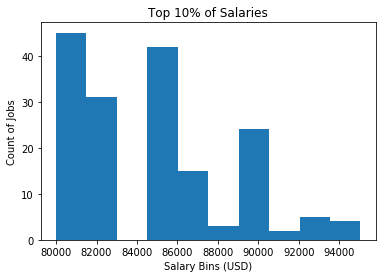

In [24]:
figure(figsize=(6,4))
plt.hist(max_salaries.Salary)
plt.xlabel('Salary Bins (USD)')
plt.ylabel('Count of Jobs')
plt.title('Top 10% of Salaries')
plt.show()

In [25]:
max_sal_corr = max_salaries.corr().iloc[0,1:]
maxwords = max_sal_corr.sort_values(ascending=False).head(10).index.values

In [26]:
print 'Top words associated with of highest 10%% of paying jobs: %s' % maxwords.tolist()

Top words associated with of highest 10% of paying jobs: ['cambridge', 'telecommunications', 'regulatory', 'architect', 'chattanooga', 'injection', 'machinist', 'laboratory', 'technical', 'indianapolis']


##### Words that are associated to the lowest salaries

In [27]:
min_salaries = df2.sort_values(by='Salary',ascending=True).head(len(df2)/10)

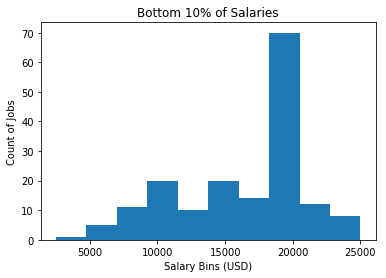

In [28]:
figure(figsize=(6,4))
plt.hist(min_salaries.Salary)
plt.xlabel('Salary Bins (USD)')
plt.ylabel('Count of Jobs')
plt.title('Bottom 10% of Salaries')
plt.show()

In [29]:
min_sal_corr = min_salaries.corr().iloc[0,1:]
minwords = min_sal_corr.sort_values(ascending=False).head(10).index.values

In [30]:
print 'Top words associated with of lowest 10%% of paying jobs: %s' % minwords.tolist()

Top words associated with of lowest 10% of paying jobs: ['facilities', 'engineering', 'regulatory', 'indianapolis', 'estimator', 'chattanooga', 'marlborough', 'springfield', 'arlington', 'louisville']
